<h1 align="center">
<span style="color: red;">$\textbf{Simon's Algorithm}$</center>
</h1>

Simon’s algorithm is a quantum computing algorithm invented to solve a contrived problem which is called Simon’s problem. Compared to one of the other quantum computing algorithms, Deutsch-Jozsa algorithm, which only requires to run once, Simon’s algorithm requires to run the algorithm multiple times, yet it is still able to solve Simon’s problem exponentially faster asymptotically running on quantum circuits than the best conventional probabilistic algorithm running on classical circuits.

$\textbf{Simon's Problem}$

Simon's problem is defined as the follows. Given a black box function $f:\{0,1\}^{n} \rightarrow\{0,1\}^{n}$

we are further assured that there exists a hidden binary string $\mathbf{c} \in\{0,1\}^{n}$, such that, for all


$\mathbf{x}, \mathbf{y} \in\{0,1\}^{n}$
$$
f(\mathbf{x})=f(\mathbf{y}) \Leftrightarrow \mathbf{y}=\mathbf{x} \oplus \mathbf{c}
$$


where $\oplus$ is (bit-wise) XOR (binary addition modulo 2).

- Our goal is to find out what $\mathbf{c}$ is.

$\textbf{There are some properties of the mapping $f . f$ is either a one-to-one or two-to-one mapping.  $\mathbf{c}=\mathbf{0} \Leftrightarrow f$ is a one-to-one mapping}$

$\textbf{Proof}$

For $f$ is a one-to-one mapping $\Rightarrow \mathbf{c}=\mathbf{0}$, it is too trivial to prove.


For $\mathbf{c}=\mathbf{0} \Rightarrow f$ is a one-to-one mapping, we would like to prove by contradiction.


If $\mathbf{c}=\mathbf{0}$ and $f$ is not a one-to-one mapping, there must exists $\mathbf{x}$ and $\mathbf{y}, \mathbf{x} \neq \mathbf{y},$ and $f(\mathbf{x})=f(\mathbf{y})$. According to the assurance, $\mathbf{y}=\mathbf{x} \oplus \mathbf{c}=\mathbf{x} \oplus \mathbf{0}=\mathbf{x}$. This raises contradiction
and therefore $f$ has to be a one-to-one mapping when $\mathbf{c}=\mathbf{0}$.


This concludes the proof.
$\mathbf{c} \neq \mathbf{0} \Leftrightarrow f$ is a two-to-one mapping.

## The Algorithm to Find the Hidden Integer

The Simon algorithm finds the hidden integer by combining quantum algorithm with postprocessing on classical computers as below. 

1. Prepare two quantum registers each of length $n$ that are initialized to all-zero bitstring: the first one as input and the second one as output of the blackbox function.
$$
|0\rangle |0\rangle
$$

2. Apply Hadamard gates to the first register to create superposition of all possible inputs. 
$$
H^{\otimes n} |0\rangle |0\rangle = \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} |x\rangle |0\rangle
$$

3. Query the blackbox function to obtain the answer to queries on the second register.
$$
\frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} U_{f_s}|x\rangle |0\rangle = \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} |x\rangle |f_s(x)\rangle
$$

4. Apply Hadamard gates to the second register. 
$$
\frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} H^{\otimes n}|x\rangle |f_s(x)\rangle = \frac{1}{2^n} \sum_{y=0}^{2^n-1}\sum_{x=0}^{2^n-1} (-1)^{x \cdot y}|y\rangle |f_s(x)\rangle = \frac{1}{2^n} \sum_{y=0}^{2^n-1} |y\rangle \sum_{x=0}^{2^n-1} ( (-1)^{x \cdot y} + (-1)^{(x\oplus s) \cdot y} )  |f_s(x)\rangle
$$

    Notice that at the right-hand side of the above equation, because $(-1)^{(x\oplus s) \cdot y} = (-1)^{(x\cdot y) +  s \cdot y}$ we can conclude that the probability amplitude of the basis state $|y\rangle |f_s(x)\rangle$ is $(-1)^{x\cdot y} ((-1) + (-1)^{s \cdot y}  )$, which is zero if and only if $s \cdot y = 1$. Thus, measuring the first register will always give $y$ such that $s \cdot y = 0$. Moreover, we can obtain many different $y$'s by repeating Step 1 to 4. 

5. Repeat Step 1 to 4 for $m$ times to obtain $y_1, y_2, \ldots, y_m$. 

6. **(Classical post-processing)** Let $\mathbf{Y}$ be an $m\times n$ matrix whose $i$-th row is $y_i$ in Step 5, and $\vec{s}$ be the column vector whose $j$-th element is the $j$-th bit of $s$. Solve the following system of linear equations to obtain $s$. 
$$
\mathbf{Y} \vec{s} = 0 
$$

In [1]:
#initialization
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing the QISKit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister,BasicAer,execute
# import basic plot tools
from qiskit.tools.visualization import plot_histogram

In [14]:
s = "1111" # the hidden bitstring

assert 1 < len(s) < 20, "The length of s must be between 2 and 19"

for c in s:
    assert c == "0" or c == "1", "s must be a bitstring of '0' and '1'"
    
n = len(s) #the length of the bitstring

In [15]:
# Step 1
# Creating registers
# qubits for querying the oracle and recording its output
qr = QuantumRegister(2*n)
# for recording the measurement on the first register of qr
cr = ClassicalRegister(n)

circuitName = "Simon"
simonCircuit = QuantumCircuit(qr, cr)

# Step 2
# Apply Hadamard gates before querying the oracle
for i in range(n):
    simonCircuit.h(qr[i])

# Apply barrier to mark the beginning of the blackbox function
simonCircuit.barrier()

### Constructing a Circuit for the Blackbox Function

We now details the construction of 1-to-1 and 2-to-1 permutation circuit of the blackbox function. Let us assume the blackbox function receive $|x\rangle|0\rangle$ as input. With regards to a predetermined $s$, the blackbox function writes its output to the second register so that it transforms the input to $|x\rangle|f_s(x)\rangle$ such that $f(x) = f(x\oplus s)$ for all $x \in \{0,1\}^n$. 

Such a blackbox function can be realized by the following procedures.

-  Copy the content of the first register to the second register.
$$
|x\rangle|0\rangle \rightarrow |x\rangle|x\rangle
$$

-  **(Creating 1-to-1 or 2-to-1 mapping)** If $s$ is not all-zero, then there is the least index $j$ so that $s_j = 1$. If $x_j = 0$, then XOR the second register with $s$. Otherwise, do not change the second register.
$$
|x\rangle|x\rangle \rightarrow |x\rangle|x \oplus s\rangle~\mbox{if}~x_j = 0~\mbox{for the least index j}
$$

-  **(Creating random permutation)** Randomly permute and flip the qubits of the second register.
$$
|x\rangle|y\rangle \rightarrow |x\rangle|f_s(y)\rangle
$$

Below is the circuit of the blacbox function based on the above procedures.

In [16]:
# Step 3 query the blackbox function
# copy the content of the first register to the second register
for i in range(n):
    simonCircuit.cx(qr[i], qr[n+i])

# get the least index j such that s_j is "1"
j = -1
for i, c in enumerate(s):
    if c == "1":
        j = i
        break

# Creating 1-to-1 or 2-to-1 mapping with the j-th qubit of x as control to XOR the second register with s
for i, c in enumerate(s):
    if c == "1" and j >= 0:
        simonCircuit.cx(qr[j], qr[n+i]) #the i-th qubit is flipped if s_i is 1

# get random permutation of n qubits
perm = list(np.random.permutation(n))

#initial position
init = list(range(n))
i = 0
while i < n:
    if init[i] != perm[i]:
        k = perm.index(init[i])
        simonCircuit.swap(qr[n+i], qr[n+k]) #swap qubits
        init[i], init[k] = init[k], init[i] #marked swapped qubits
    else:
        i += 1
        
# randomly flip the qubit
for i in range(n):
    if np.random.random() > 0.5:
        simonCircuit.x(qr[n+i])

# Apply the barrier to mark the end of the blackbox function
simonCircuit.barrier()

In [17]:
# Step 4 apply Hadamard gates to the first register
for i in range(n):
    simonCircuit.h(qr[i])
    
# Step 5 perform measurement on the first register
for i in range(n):
    simonCircuit.measure(qr[i], cr[i])

#draw the circuit
from qiskit.tools.visualization import circuit_drawer
circuit_drawer(simonCircuit)

┌───┐ ░                                                            ░ »
q13_0: ┤ H ├─░───■───────────────────■────■────■────■─────────────────────░─»
       ├───┤ ░   │                   │    │    │    │                     ░ »
q13_1: ┤ H ├─░───┼────■──────────────┼────┼────┼────┼─────────────────────░─»
       ├───┤ ░   │    │              │    │    │    │                     ░ »
q13_2: ┤ H ├─░───┼────┼────■─────────┼────┼────┼────┼─────────────────────░─»
       ├───┤ ░   │    │    │         │    │    │    │                     ░ »
q13_3: ┤ H ├─░───┼────┼────┼────■────┼────┼────┼────┼─────────────────────░─»
       └───┘ ░ ┌─┴─┐  │    │    │  ┌─┴─┐  │    │    │                     ░ »
q13_4: ──────░─┤ X ├──┼────┼────┼──┤ X ├──┼────┼────┼───X───X────X────────░─»
             ░ └───┘┌─┴─┐  │    │  └───┘┌─┴─┐  │    │   │   │    │  ┌───┐ ░ »
q13_5: ──────░──────┤ X ├──┼────┼───────┤ X ├──┼────┼───┼───┼────X──┤ X ├─░─»
             ░      └───┘┌─┴─┐  │       └───┘┌─┴─┐  │   │   │  ┌───┐└───┘ ░ »
q13_6: ──────░───────────┤ X ├──┼────────────┤ X ├──┼───┼───X──┤ X ├──────░─»
             ░           └───┘┌─┴─┐          └───┘┌─┴─┐ │ ┌───┐└───┘      ░ »
q13_7: ──────░────────────────┤ X ├───────────────┤ X ├─X─┤ X ├───────────░─»
             ░                └───┘               └───┘   └───┘           ░ »
 c2: 4/═════════════════════════════════════════════════════════════════════»
                                                                            »
«       ┌───┐┌─┐         
«q13_0: ┤ H ├┤M├─────────
«       ├───┤└╥┘┌─┐      
«q13_1: ┤ H ├─╫─┤M├──────
«       ├───┤ ║ └╥┘┌─┐   
«q13_2: ┤ H ├─╫──╫─┤M├───
«       ├───┤ ║  ║ └╥┘┌─┐
«q13_3: ┤ H ├─╫──╫──╫─┤M├
«       └───┘ ║  ║  ║ └╥┘
«q13_4: ──────╫──╫──╫──╫─
«             ║  ║  ║  ║ 
«q13_5: ──────╫──╫──╫──╫─
«             ║  ║  ║  ║ 
«q13_6: ──────╫──╫──╫──╫─
«             ║  ║  ║  ║ 
«q13_7: ──────╫──╫──╫──╫─
«             ║  ║  ║  ║ 
« c2: 4/══════╩══╩══╩══╩═
«             0  1  2  3

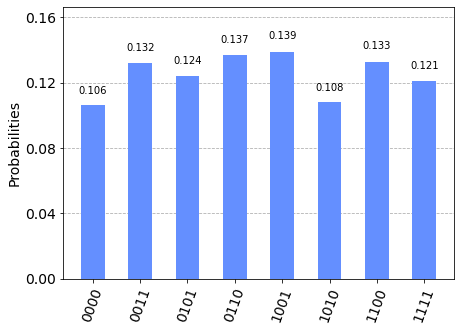

In [18]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(simonCircuit, backend=backend, shots=shots).result()
counts = results.get_counts()
plot_histogram(counts)

In [19]:
# Calculate the dot product of the results
def bdotz(s, z):
    accum = 0
    for i in range(len(s)):
        accum += int(s[i]) * int(z[i])
    return (accum % 2)

for z in counts:
    print( '{}.{} = {} (mod 2)'.format(s, z, bdotz(s,z)) )

1111.0011 = 0 (mod 2)
1111.1111 = 0 (mod 2)
1111.0110 = 0 (mod 2)
1111.0101 = 0 (mod 2)
1111.1001 = 0 (mod 2)
1111.1100 = 0 (mod 2)
1111.0000 = 0 (mod 2)
1111.1010 = 0 (mod 2)


References
1. https://leimao.github.io/blog/Simon-Algorithm/
2. https://www.youtube.com/watch?v=yhd7V0-BIrs&ab_channel=AnantVigyan